In [40]:
# Importa a gdal
from osgeo import gdal

# Importa a gdalconst
from gdalconst import *

# Uso de exceções
gdal.UseExceptions()

# Importa o matplotlib
import matplotlib.pyplot as plt

# Importa o Numpy
import numpy as np

# Importa os widgets
import ipywidgets as widgets

### Função que abre e retorna a imagem NIR do CBERS para calcular a máscara de nuvens:

In [35]:
# Função para abrir dataset:
def abrir_dataset (nome_arquivo):
    print ("Abrindo o arquivo: " + nome_arquivo)
    
    # Tenta abrir a imagem
    dataset = None
    try:
        dataset = gdal.Open(nome_arquivo, GA_ReadOnly)
        print("Arquivo aberto com sucesso!")
    except:
        print("Erro na abertura do arquivo!")
    
    return dataset

### Usuário seleciona a imagem

In [36]:
# Pedir pro usuário o caminho para a imagem:
lista_imagens = ['../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif']

# Cria um dropdown com a lista de imagens
nome_arquivo_NIR = widgets.Dropdown(
    options = lista_imagens
)

print ("Caminho do arquivo NIR:")
nome_arquivo_NIR

Caminho do arquivo NIR:


Dropdown(options=('../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif',), value='../…

### Abre o dataset e converte a banda NIR para array

In [37]:
# Abre a imagem NIR:
raster_NIR = abrir_dataset(nome_arquivo_NIR.value)
# Obtém a banda única do dataset
banda_NIR = raster_NIR.GetRasterBand(1)
# Transforma a banda em array
array_banda_NIR = banda_NIR.ReadAsArray()

Abrindo o arquivo: ../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif
Arquivo aberto com sucesso!


# Calcula a máscara de nuvens

### Usuário seleciona o limiar

In [41]:
# Define o limiar
limiar = widgets.IntSlider( min=0, max=255, value=120, step=1)
limiar

IntSlider(value=120, max=255)

### Valores acima do limiar são nuvens e ficam valendo 1. Valores abaixo do limiar valem 0.

In [42]:
# Cria uma cópia da banda NIR para trabalhar
mascara_nuvens = np.copy(array_banda_NIR)

# Cria a máscara em função do limiar
mascara_nuvens[mascara_nuvens < limiar.value] = False
mascara_nuvens[mascara_nuvens >= limiar.value] = True

# Estatísticas

In [39]:
print("Estatísticas:")
print("")

print("Valores banda NIR:")
print("Min: ", array_banda_NIR.min())
print("Max: ", array_banda_NIR.max())
print("")

print("Valores máscara de Núvens:")
print("Min: ", mascara_nuvens.min())
print("Max: ", mascara_nuvens.max())
print("")

num_total_pixels = mascara_nuvens.size
print ("Número total de pixels:", num_total_pixels)

num_pixels_nuvem = len(mascara_nuvens[mascara_nuvens == 1])
print ("Número total de pixels com nuvens:", num_pixels_nuvem)

per_pixels_nuvem = (num_pixels_nuvem/num_total_pixels)*100
# per_pixels_nuvem = 80
print ("Percentual de pixels com nuvens:", (round(per_pixels_nuvem, 3)))

if (per_pixels_nuvem > 75):
    print("Céu totalmente coberto")
elif (per_pixels_nuvem > 20):
    print("Céu parcialmente coberto")
else:
    print("Céu limpo")

Estatísticas:

Valores banda NIR:
Min:  0
Max:  255

Valores máscara de Núvens:
Min:  0
Max:  1

Número total de pixels: 54788591
Número total de pixels com nuvens: 5461125
Percentual de pixels com nuvens: 9.968
Céu limpo


# Mostra a imagem NIR e a Máscara de Nuvens ao lado

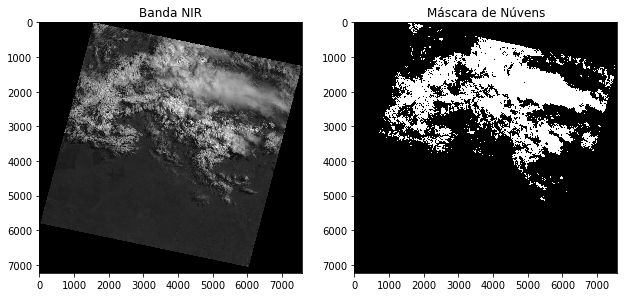

In [8]:
# Cria a figura
plt.figure(figsize = (16, 8))

# Mostra a imagem NIR
plt.subplot(131)
plt.title("Banda NIR")
plt.imshow(array_banda_NIR, cmap='gray');

# Mostra a máscara de nuvens
plt.subplot(132)
plt.title("Máscara de Núvens")
plt.imshow(mascara_nuvens, cmap='gray');

# Salva a máscara como arquivo tif

In [9]:
def salvar_banda(matriz_de_pixels, nome_do_arquivo, dataset_de_referencia):
    # Obtém as informações de tamanho do raster de referência
    linhas = dataset_de_referencia.RasterYSize
    colunas = dataset_de_referencia.RasterXSize
    bandas = 1
        
    # Carrega o driver para salvar tif
    driver = gdal.GetDriverByName('GTiff')
    
    # Obtém o tipo de dado do dataset de referência
    data_type = dataset_de_referencia.GetRasterBand(1).DataType
    
    # Criar novo dataset
    dataset_output = driver.Create(nome_do_arquivo, colunas, linhas, bandas, data_type)
    
    # copiar informações espaciais da banda já existente
    dataset_output.SetGeoTransform(dataset_de_referencia.GetGeoTransform())
    
    # copiar informações de projeção
    dataset_output.SetProjection(dataset_de_referencia.GetProjectionRef())
    
    # escrever dados da matriz NumPy na banda
    dataset_output.GetRasterBand(1).WriteArray(matriz_de_pixels)
    
    # salvar valores
    dataset_output.FlushCache()
    
    # fechar dataset
    dataset_output = None

In [10]:
# Nome do arquivo de saída
nome_arquivo_mascara_destino = '../imagens/mascara_nuvens_CBERS_20180131.tif'

# Chama a função para salvar a máscara de nuvens
salvar_banda(mascara_nuvens, nome_arquivo_mascara_destino, raster_NIR)